## Create folders & Dataset v3 CSV

In [34]:
import os
import pandas as pd

# 1) Ensure data folder exists
os.makedirs("data", exist_ok=True)

# 2) Build Dataset v4 with Ramattra included
df = pd.DataFrame({
    'Hero': [
        'Genji', 'Hanzo',
        'Mercy', 'Ana', 'Kiriko',
        'Reinhardt', 'Zarya', 'Ramattra',
        'Tracer'
    ],
    'Mobility': [
        9, 7,        # Genji, Hanzo (high mobility DPS)
        4, 3, 8,     # Mercy, Ana, Kiriko (low→high mobility supports)
        3, 4, 5,     # Rein, Zarya, Ramattra (tank mobility baseline, Ramattra slightly higher)
        10           # Tracer (max mobility wildcard)
    ],
    'Self_Sustain': [
        3, 2,        # Genji, Hanzo (low)
        1, 5, 7,     # Mercy, Ana, Kiriko (varied sustain support)
        1, 6, 7,     # Rein, Zarya, Ramattra (Ramattra high via block + armor + vortex)
        1            # Tracer (low sustain, high evasion instead)
    ],
    'Mechanical_Skill': [
        9, 8,        # Genji, Hanzo (high aim complexity)
        5, 9, 6,     # Mercy, Ana, Kiriko (varied support mechanics)
        5, 7, 7,     # Rein, Zarya, Ramattra (Ramattra tactical cooldown mastery)
        6            # Tracer (tracking + blink management)
    ],
    'HP': [
        200, 200,    # Genji, Hanzo
        200, 200, 200, # Support HP
        550, 475, 450,  # Reinhardt, Zarya, Ramattra base HP
        150          # Tracer
    ],
    'Damage': [
        1, 1,   # Genji, Hanzo
        0, 0, 0, # Supports
        0, 0, 0, # Tanks
        1        # Tracer
    ],
    'Support': [
        0, 0,
        1, 1, 1,
        0, 0, 0,
        0
    ],
    'Tank': [
        0, 0,
        0, 0, 0,
        1, 1, 1,
        0
    ]
})

# 3) Save final dataset
df.to_csv("data/overwatch_hero_psychology.csv", index=False)
print("Dataset v4 with Ramattra saved to data/overwatch_hero_psychology.csv")
df

Dataset v4 with Ramattra saved to data/overwatch_hero_psychology.csv


,Hero,Mobility,Self_Sustain,Mechanical_Skill,HP,Damage,Support,Tank
0,Genji,9,3,9,200,1,0,0
1,Hanzo,7,2,8,200,1,0,0
2,Mercy,4,1,5,200,0,1,0
3,Ana,3,5,9,200,0,1,0
4,Kiriko,8,7,6,200,0,1,0
5,Reinhardt,3,1,5,550,0,0,1
6,Zarya,4,6,7,475,0,0,1
7,Ramattra,5,7,7,450,0,0,1
8,Tracer,10,1,6,150,1,0,0


## Requirements helper 

In [2]:
open("requirements.txt","w").write(
"""pandas
numpy
scikit-learn
matplotlib
seaborn
"""
)
print("requirements.txt written")

requirements.txt written


## Load and Scale Data 

In [35]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load updated dataset v4 with Ramattra
df = pd.read_csv("data/overwatch_hero_psychology.csv")

# Define features
num_features = ['Mobility', 'Self_Sustain', 'Mechanical_Skill', 'HP']
role_cols = ['Damage', 'Support', 'Tank']
all_features = num_features + role_cols

# Z-score normalization (standard scaling)
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[num_features] = scaler.fit_transform(df[num_features])

df_scaled

,Hero,Mobility,Self_Sustain,Mechanical_Skill,HP,Damage,Support,Tank
0,Genji,1.237437,-0.272166,1.457233,-0.635085,1,0,0
1,Hanzo,0.441942,-0.680414,0.766965,-0.635085,1,0,0
2,Mercy,-0.751301,-1.088662,-1.303840,-0.635085,0,1,0
3,Ana,-1.149049,0.544331,1.457233,-0.635085,0,1,0
4,Kiriko,0.839689,1.360828,-0.613572,-0.635085,0,1,0
5,Reinhardt,-1.149049,-1.088662,-1.303840,1.789786,0,0,1
6,Zarya,-0.751301,0.952579,0.076696,1.270171,0,0,1
7,Ramattra,-0.353553,1.360828,0.076696,1.096966,0,0,1
8,Tracer,1.635184,-1.088662,-0.613572,-0.981495,1,0,0


## Cosine similarity matrix + save to CSV

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between all heroes
sim_matrix = cosine_similarity(df_scaled[all_features])
sim_df = pd.DataFrame(sim_matrix, index=df['Hero'], columns=df['Hero'])

# Save for reference
sim_df.to_csv("outputs/similarity_matrix.csv")

sim_df  # display

Hero,Genji,Hanzo,Mercy,Ana,Kiriko,Reinhardt,Zarya,Ramattra,Tracer
Hero,,,,,,,,,
Genji,1.000000,0.882121,-0.426812,0.186234,0.037711,-0.633590,-0.411127,-0.300487,0.540561
Hanzo,0.882121,1.000000,-0.052414,0.174115,-0.183510,-0.403301,-0.524832,-0.516440,0.645501
Mercy,-0.426812,-0.052414,1.000000,-0.045231,0.019834,0.408854,-0.309543,-0.446513,0.251606
Ana,0.186234,0.174115,-0.045231,1.000000,0.060368,-0.351090,0.149743,0.121136,-0.485657
Kiriko,0.037711,-0.183510,0.019834,0.060368,1.000000,-0.460853,-0.044702,0.190402,0.171918
Reinhardt,-0.633590,-0.403301,0.408854,-0.351090,-0.460853,1.000000,0.511415,0.301385,-0.228593
Zarya,-0.411127,-0.524832,-0.309543,0.149743,-0.044702,0.511415,1.000000,0.957190,-0.706787
Ramattra,-0.300487,-0.516440,-0.446513,0.121136,0.190402,0.301385,0.957190,1.000000,-0.624920
Tracer,0.540561,0.645501,0.251606,-0.485657,0.171918,-0.228593,-0.706787,-0.624920,1.000000


## Archetype centroids + rankings (Top N)

In [37]:
import pandas as pd

# Helper: centroid of heroes (Module 3 Query Concept)
def centroid(hero_list):
    return df_scaled.set_index('Hero').loc[hero_list, all_features].mean().values

# Define archetypes
solo_centroid      = centroid(['Genji', 'Hanzo'])
healer_centroid    = centroid(['Mercy', 'Ana', 'Kiriko'])
protector_centroid = centroid(['Reinhardt', 'Zarya'])

# Rank all heroes against each centroid
from sklearn.metrics.pairwise import cosine_similarity

def rank_similar(query_vec):
    scores = cosine_similarity([query_vec], df_scaled[all_features])[0]
    return pd.Series(scores, index=df['Hero']).sort_values(ascending=False)

# Get updated rankings with Ramattra included
solo_rank      = rank_similar(solo_centroid)
healer_rank    = rank_similar(healer_centroid)
protector_rank = rank_similar(protector_centroid)

solo_rank, healer_rank, protector_rank

(Hero
 Genji        0.979211
 Hanzo        0.959327
 Tracer       0.601956
 Ana          0.186598
 Kiriko      -0.056427
 Mercy       -0.278372
 Ramattra    -0.402494
 Zarya       -0.472418
 Reinhardt   -0.553409
 dtype: float64,
 Hero
 Ana          0.599680
 Kiriko       0.591600
 Mercy        0.559860
 Hanzo       -0.026858
 Tracer      -0.049444
 Ramattra    -0.081667
 Zarya       -0.113817
 Genji       -0.114851
 Reinhardt   -0.223581
 dtype: float64,
 Hero
 Reinhardt    0.914708
 Zarya        0.815066
 Ramattra     0.653330
 Mercy        0.130084
 Ana         -0.166288
 Kiriko      -0.331732
 Tracer      -0.486497
 Hanzo       -0.518719
 Genji       -0.620510
 dtype: float64)

## Export ranking tables (Markdown + CSV)

In [38]:
import os

# Ensure outputs directory exists
os.makedirs("outputs", exist_ok=True)

def save_ranking(name, series):
    # Save as CSV
    series.to_csv(f"outputs/{name}_ranking.csv", header=['similarity'])
    # Save as Markdown for Medium
    lines = ["| Hero | Similarity Score |", "|------|------------------|"]
    for hero, score in series.items():
        lines.append(f"| {hero} | {score:.3f} |")
    with open(f"outputs/{name}_ranking.md", "w") as f:
        f.write("\n".join(lines))

save_ranking("solo_mastery", solo_rank)
save_ranking("healer_psyche", healer_rank)
save_ranking("protector_guardian", protector_rank)

print("Updated Ranking Tables Saved to 'outputs/'")
print("\n--- Solo Mastery Archetype ---")
print(solo_rank)
print("\n--- Healer Psyche Archetype ---")
print(healer_rank)
print("\n--- Protector Guardian Archetype ---")
print(protector_rank)

Updated Ranking Tables Saved to 'outputs/'

--- Solo Mastery Archetype ---
Hero
Genji        0.979211
Hanzo        0.959327
Tracer       0.601956
Ana          0.186598
Kiriko      -0.056427
Mercy       -0.278372
Ramattra    -0.402494
Zarya       -0.472418
Reinhardt   -0.553409
dtype: float64

--- Healer Psyche Archetype ---
Hero
Ana          0.599680
Kiriko       0.591600
Mercy        0.559860
Hanzo       -0.026858
Tracer      -0.049444
Ramattra    -0.081667
Zarya       -0.113817
Genji       -0.114851
Reinhardt   -0.223581
dtype: float64

--- Protector Guardian Archetype ---
Hero
Reinhardt    0.914708
Zarya        0.815066
Ramattra     0.653330
Mercy        0.130084
Ana         -0.166288
Kiriko      -0.331732
Tracer      -0.486497
Hanzo       -0.518719
Genji       -0.620510
dtype: float64


## Radar charts (matplotlib only)

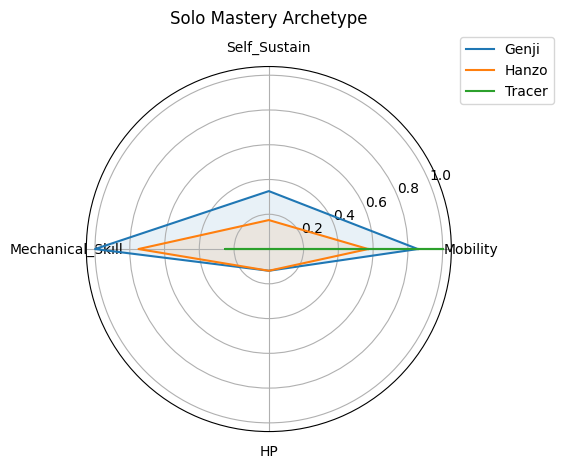

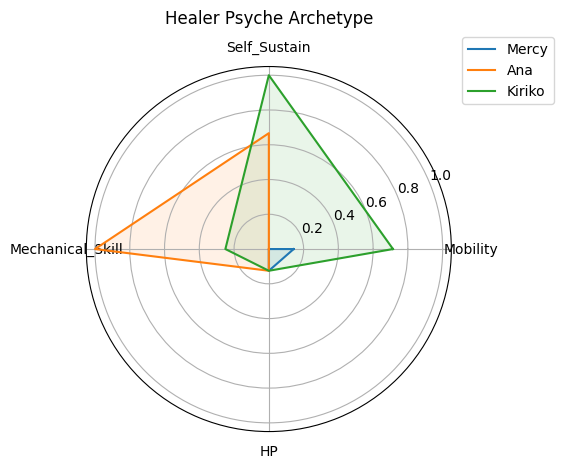

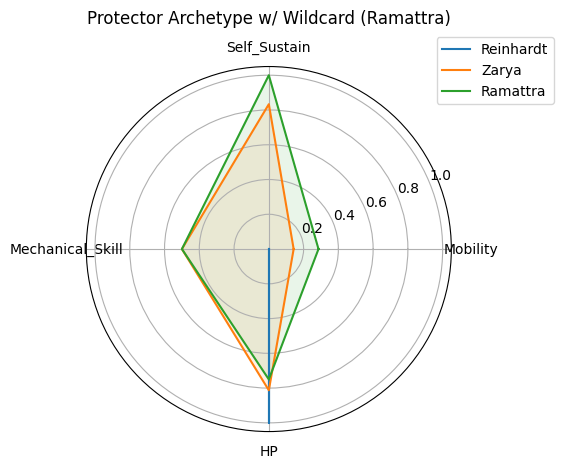

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Normalize only numerical features for radar (0-1 scale)
min_vals = df[num_features].min()
max_vals = df[num_features].max()
df_norm = (df.set_index('Hero')[num_features] - min_vals) / (max_vals - min_vals)

# Ensure visuals folder exists
os.makedirs("visuals", exist_ok=True)

def plot_radar(heroes, title, save_path=None):
    data = df_norm.loc[heroes]
    labels = data.columns.tolist()
    num_vars = len(labels)
    angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
    for hero in heroes:
        values = data.loc[hero].tolist()
        values += values[:1]
        ax.plot(angles, values, label=hero)
        ax.fill(angles, values, alpha=0.10)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title(title, pad=12)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200)
    plt.show()

# Existing charts:
plot_radar(['Genji', 'Hanzo', 'Tracer'], 'Solo Mastery Archetype', 'visuals/radar_solo_mastery.png')
plot_radar(['Mercy', 'Ana', 'Kiriko'], 'Healer Psyche Archetype', 'visuals/radar_healer_psyche.png')
plot_radar(['Reinhardt', 'Zarya', 'Ramattra'], 'Protector Archetype w/ Wildcard (Ramattra)', 'visuals/radar_protector_ramattra.png')

## Heatmaps (seaborn) 

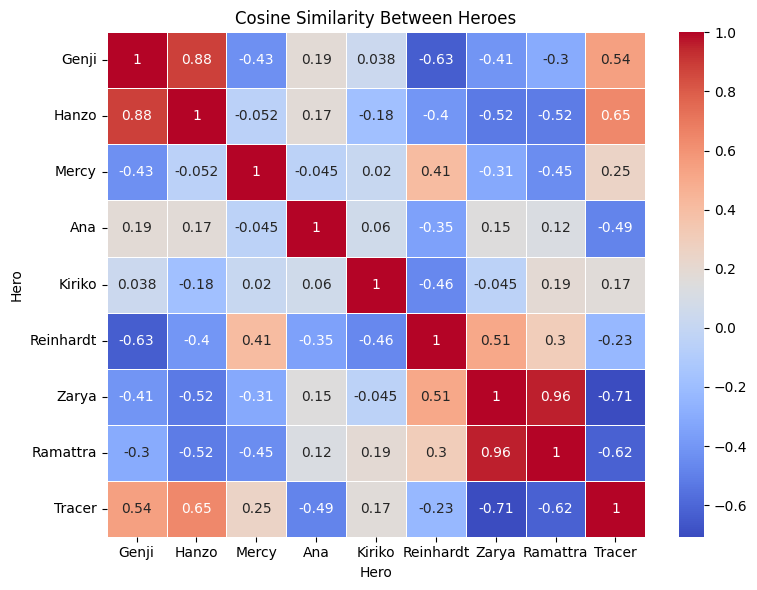

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(sim_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Cosine Similarity Between Heroes')
plt.tight_layout()
plt.savefig('visuals/similarity_heatmap.png', dpi=200)
plt.show()